# Initial setup

This section includes installing required libraries and loading environment variables, also making sure GPUs are visible.

### Libraries

In [10]:
import importlib.util

def install_if_not_exists(package_name, no_deps=False):
    spec = importlib.util.find_spec(package_name)
    if spec is None:
        print(f"[+] Installing {package_name}...")
        if no_deps is False:
          !pip install {package_name} --quiet
        else:
          !pip install --no-deps {package_name} --quiet
    else:
        print(f"[-] {package_name} is already installed.")

In [11]:
# training
install_if_not_exists("torch", no_deps=False)
install_if_not_exists("transformers", no_deps=False)

# datasets
install_if_not_exists("datasets", no_deps=False)
install_if_not_exists("scikit-learn", no_deps=False)
install_if_not_exists("pandas", no_deps=False)
install_if_not_exists("pymongo", no_deps=False)

# other
install_if_not_exists("matplotlib", no_deps=False)
install_if_not_exists("python-dotenv", no_deps=False)

# wandb and deps
install_if_not_exists("sentry-sdk")
install_if_not_exists("setproctitle", no_deps=False)
# install_if_not_exists("wandb", no_deps=False)
install_if_not_exists("click", no_deps=False)
install_if_not_exists("docker-pycreds", no_deps=False)
install_if_not_exists("nltk", no_deps=False)

[-] torch is already installed.
[-] transformers is already installed.
[-] datasets is already installed.
[+] Installing scikit-learn...
[-] pandas is already installed.
[-] pymongo is already installed.
[-] matplotlib is already installed.
[+] Installing python-dotenv...
[+] Installing sentry-sdk...
[-] setproctitle is already installed.
[-] click is already installed.
[+] Installing docker-pycreds...
[-] nltk is already installed.


In [12]:
# core
import os, logging, time, torch, gc, re
from dotenv import load_dotenv
import numpy as np

# dataset
from datasets import Dataset
from pymongo import MongoClient
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader

# training
import torch
from transformers import(
    EarlyStoppingCallback,
    AdamW,
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    DistilBertConfig,
    BertTokenizer,
    BertForSequenceClassification,
    BertConfig,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    RobertaConfig,
    Trainer,
    TrainingArguments,
    AdamW,
    get_linear_schedule_with_warmup
)


# evaluation
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
from bert_utils import *

### Environment variables and constants

In [13]:
load_dotenv(".env")
CONNECTION_STRING = os.getenv("CONNECTION_STRING")
TOKEN = os.getenv("HUGGINGFACE_TOKEN")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2"

In [14]:
DATABASE_NAME = "APTs"

In [15]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/dalgora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dalgora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Dataset loading


Initially, we will be building a dataset with raw text and tools. The dataset is stored in a MongoDB database, so we will have to fetch the data:

In [16]:
collection_name = "dataset"

In [17]:
df_one_hot_encoded = get_onehot_data(DATABASE_NAME, collection_name, client_uri=CONNECTION_STRING)

dict_keys(['_id', 'corpus', 'hash', 'techniques', 'tactics', 'procedures', 'IOCs', 'killchain_phase', 'apt_group'])
[+] Shape: (156, 2)
[+] One-Hot Encoded DataFrame Shape: (156, 18)


In [18]:
df_one_hot_encoded

,corpus,tactics_length,Execution,Persistence,Credential Access,Collection,Defense Evasion,Privilege Escalation,Exfiltration,Command and Control,Discovery,Initial Access,Reconnaissance,Lateral Movement,Impact,Resource Development,Delivery,Exploitation
0,decoding network data gh0st rat variant nccgro...,4,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,5www .prevailion.com /what-wicked-webs-we-unwe...,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,7www .mandiant.com /resources/blog/lightshift-...,3,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,2015/11/24 russian financial cybercrime works ...,3,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,9/28/21 4:23 pm foggyw eb argeted nobelium mal...,3,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,first release time 14:32 may 27 2015 updated t...,4,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
152,10/1/2019 helo innti attack scan lastline http...,5,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0
153,9/9/2020 teamtnt activity tar gets eave scope ...,5,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0
154,2stisc-gov-md.translate.goog /ro/stisc-atentie...,3,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import torch

In [20]:
os.environ["NCCL_IB_DISABLE"] = "1"
os.environ["NCCL_SHM_DISABLE"] = "1"

# Dataset preparation

A custom dataset class `CustomDataset` was created in order to be handled with data loaders (for Bert compatibility)

In [21]:
# tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

texts = df_one_hot_encoded['corpus'].tolist()
labels = df_one_hot_encoded.drop(columns=['corpus', 'tactics_length']).values

Small `TypeError` fix

In [22]:
def convert_to_float32(x):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        return np.array(x, dtype=np.float32)
    else:
        return np.float32(x)

Another small fix to make sure labels are a 2D array

In [23]:
labels_list = list(labels)
# making sure they are all the same length
max_length = max(len(label) for label in labels_list)
for i in range(len(labels_list)):
    if len(labels_list[i]) < max_length:
        labels_list[i] = np.pad(labels_list[i], (0, max_length - len(labels_list[i])), 'constant')

labels = np.vstack(labels_list) # stacking the labels into a 2D array

Generating the custom training and validation datasets

In [24]:
train_dataset, val_dataset, test_dataset = prepare_datasets(texts, labels, tokenizer=tokenizer)

<Figure size 1000x600 with 0 Axes>

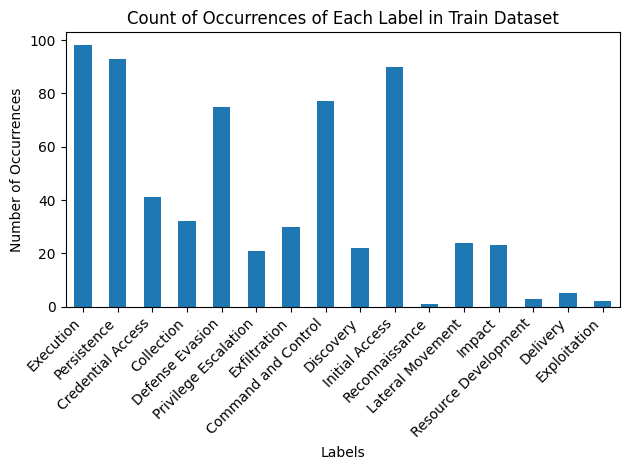

<Figure size 1000x600 with 0 Axes>

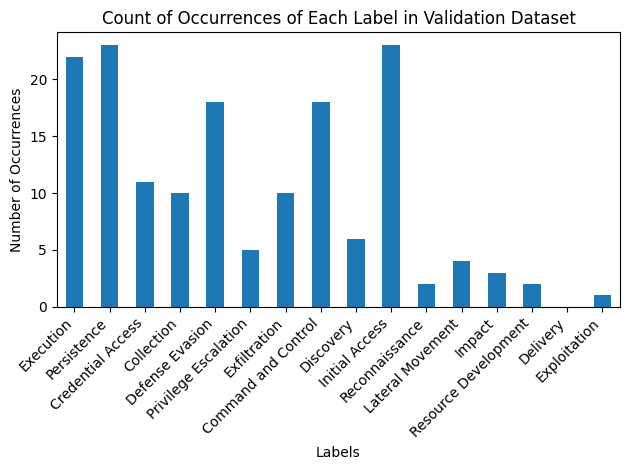

<Figure size 1000x600 with 0 Axes>

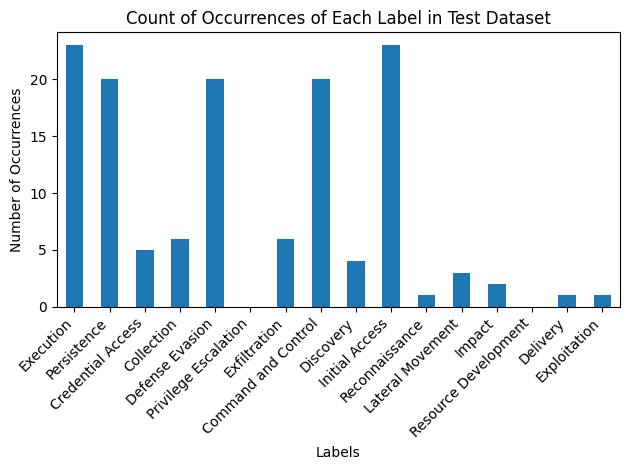

In [26]:
label_names = df_one_hot_encoded.columns[2:]

train_labels_df = pd.DataFrame(train_dataset.labels, columns=label_names)
val_labels_df = pd.DataFrame(val_dataset.labels, columns=label_names)
test_labels_df = pd.DataFrame(test_dataset.labels, columns=label_names)

def plot_label_occurrences_single(label_names, labels_df, dataset_name):
    label_counts = labels_df.sum()

    label_counts_df = pd.DataFrame(label_counts, columns=['Count'])

    plt.figure(figsize=(10, 6))
    label_counts_df.plot(kind='bar', legend=False)
    plt.xlabel('Labels')
    plt.ylabel('Number of Occurrences')
    plt.title(f'Count of Occurrences of Each Label in {dataset_name} Dataset')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# label occurrences for train_labels
plot_label_occurrences_single(label_names, train_labels_df, "Train")

# label occurrences for val_labels
plot_label_occurrences_single(label_names, val_labels_df, "Validation")

# label occurrences for test_labels
plot_label_occurrences_single(label_names, test_labels_df, "Test")

# Bert model and training

In [27]:
num_labels = labels.shape[1]
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
data_collator = DataCollatorWithPadding(tokenizer)

In [29]:
model.config.hidden_dropout_prob = 0.3
model.config.attention_dropout_prob = 0.3

In [30]:
training_args = TrainingArguments(
    num_train_epochs=80,       # total number of training epochs
    per_device_train_batch_size=8,           # batch size per device during training
    per_device_eval_batch_size=8,            # batch size for evaluation
    warmup_steps=500,                        # number of warmup steps for learning rate scheduler
    weight_decay=3.5405098270915394e-05,     # strength of weight decay
    logging_dir='./logs/',                   # directory for storing logs
    logging_steps=10,
    eval_steps=10,
    save_steps=10,
    evaluation_strategy='epoch',
    save_strategy="epoch",
    learning_rate=1.5405098270915394e-06,
    metric_for_best_model="eval_loss",       # set the metric for the best model
    load_best_model_at_end=True,             # load the best model at the end of training
    output_dir='./outputs'
)

optimizer = AdamW(model.parameters(), lr=training_args.learning_rate, weight_decay=training_args.weight_decay)
scheduler = CustomReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01)



/home/dalgora/.local/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/dalgora/.local/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(optimizer, scheduler),
    callbacks=[CustomTrainerCallback(scheduler)]
)

In [32]:
# trainer.add_callback(CustomTrainerCallback())

In [33]:
training_logs = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: w-dan (seclab-etsisi). Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,No log,0.726129
2,0.734800,0.710274
3,0.709600,0.692118
4,0.709600,0.663685
5,0.685200,0.622231
6,0.639900,0.611187
7,0.639900,0.602836
8,0.614600,0.591228
9,0.596500,0.583680
10,0.586000,0.575067


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

In [34]:
results = trainer.evaluate()
print(results)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.44077926874160767, 'eval_runtime': 0.4858, 'eval_samples_per_second': 47.34, 'eval_steps_per_second': 4.117, 'epoch': 80.0}


# Evaluation

In [35]:
def predict(val_dataset):
    predictions = trainer.predict(val_dataset)
    pred_probs = torch.sigmoid(torch.tensor(predictions.predictions))
    pred_labels = (pred_probs >= 0.5).int().numpy()
    return pred_labels

def evaluate_predictions(true_labels, pred_labels):
    target_names = [f'Class {i}' for i in range(true_labels.shape[1])]
    print(classification_report(true_labels, pred_labels, target_names=target_names))
    cm = multilabel_confusion_matrix(true_labels, pred_labels)

    fig, axes = plt.subplots(nrows=cm.shape[0], figsize=(10, cm.shape[0] * 4))
    for i, ax in enumerate(axes):
        sns.heatmap(cm[i], annot=True, fmt='d', xticklabels=['Not ' + target_names[i], target_names[i]],
                    yticklabels=['Not ' + target_names[i], target_names[i]], ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'Confusion Matrix for {target_names[i]}')

    plt.tight_layout()
    plt.show()

In [36]:
sorted_labels=df_one_hot_encoded.columns[2:]
sorted_labels

Index(['Execution', 'Persistence', 'Credential Access', 'Collection',
       'Defense Evasion', 'Privilege Escalation', 'Exfiltration',
       'Command and Control', 'Discovery', 'Initial Access', 'Reconnaissance',
       'Lateral Movement', 'Impact', 'Resource Development', 'Delivery',
       'Exploitation'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98        22
     Class 1       1.00      1.00      1.00        23
     Class 2       1.00      0.18      0.31        11
     Class 3       0.00      0.00      0.00        10
     Class 4       0.78      1.00      0.88        18
     Class 5       0.00      0.00      0.00         5
     Class 6       0.00      0.00      0.00        10
     Class 7       0.78      1.00      0.88        18
     Class 8       0.00      0.00      0.00         6
     Class 9       1.00      1.00      1.00        23
    Class 10       0.00      0.00      0.00         2
    Class 11       0.00      0.00      0.00         4
    Class 12       0.00      0.00      0.00         3
    Class 13       0.00      0.00      0.00         2
    Class 14       0.00      0.00      0.00         0
    Class 15       0.00      0.00      0.00         1

   micro avg       0.91      0.67      0.77       158
   macro avg       0.35   

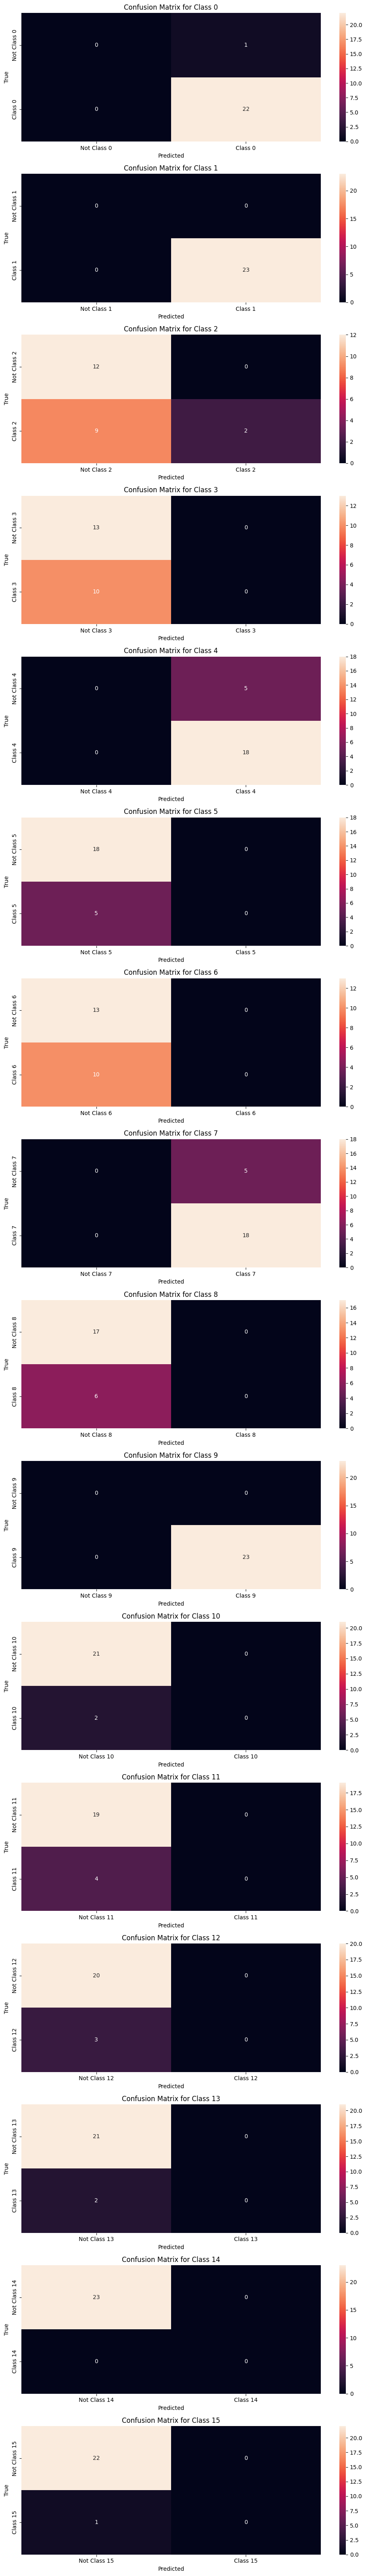

In [38]:
pred_labels = predict(val_dataset)
evaluate_predictions(val_dataset.labels, pred_labels)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98        23
     Class 1       0.83      1.00      0.91        20
     Class 2       0.00      0.00      0.00         5
     Class 3       0.00      0.00      0.00         6
     Class 4       0.83      1.00      0.91        20
     Class 5       0.00      0.00      0.00         0
     Class 6       0.00      0.00      0.00         6
     Class 7       0.83      1.00      0.91        20
     Class 8       0.00      0.00      0.00         4
     Class 9       0.96      1.00      0.98        23
    Class 10       0.00      0.00      0.00         1
    Class 11       0.00      0.00      0.00         3
    Class 12       0.00      0.00      0.00         2
    Class 13       0.00      0.00      0.00         0
    Class 14       0.00      0.00      0.00         1
    Class 15       0.00      0.00      0.00         1

   micro avg       0.88      0.79      0.83       135
   macro avg       0.28   

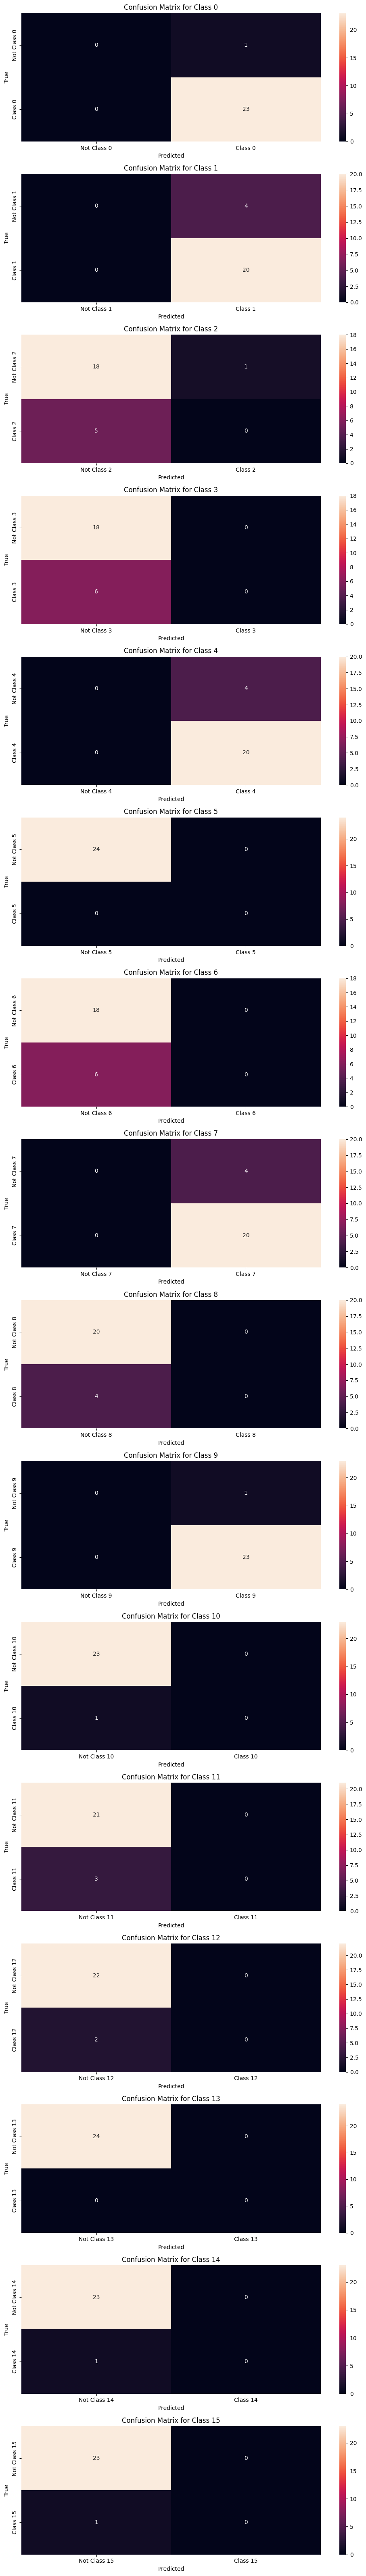

In [39]:
pred_labels_test = predict(test_dataset)
evaluate_predictions(test_dataset.labels, pred_labels_test)

In [40]:
training_logs

TrainOutput(global_step=560, training_loss=0.5015211760997772, metrics={'train_runtime': 1317.0258, 'train_samples_per_second': 6.621, 'train_steps_per_second': 0.425, 'total_flos': 2294616800624640.0, 'train_loss': 0.5015211760997772, 'epoch': 80.0})

In [41]:
def evaluate_predictions_single_matrix(true_labels, pred_labels):
    target_names = [f'Class {i}' for i in range(true_labels.shape[1])]

    print(classification_report(true_labels, pred_labels, target_names=target_names))

    true_labels_flat = true_labels.flatten()
    pred_labels_flat = pred_labels.flatten()

    cm = confusion_matrix(true_labels_flat, pred_labels_flat)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Not Predicted', 'Predicted'],
                yticklabels=['Not True', 'True'], cmap='viridis')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


Test evaluation (single confusion matrix)

/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98        23
     Class 1       0.83      1.00      0.91        20
     Class 2       0.00      0.00      0.00         5
     Class 3       0.00      0.00      0.00         6
     Class 4       0.83      1.00      0.91        20
     Class 5       0.00      0.00      0.00         0
     Class 6       0.00      0.00      0.00         6
     Class 7       0.83      1.00      0.91        20
     Class 8       0.00      0.00      0.00         4
     Class 9       0.96      1.00      0.98        23
    Class 10       0.00      0.00      0.00         1
    Class 11       0.00      0.00      0.00         3
    Class 12       0.00      0.00      0.00         2
    Class 13       0.00      0.00      0.00         0
    Class 14       0.00      0.00      0.00         1
    Class 15       0.00      0.00      0.00         1

   micro avg       0.88      0.79      0.83       135
   macro avg       0.28   

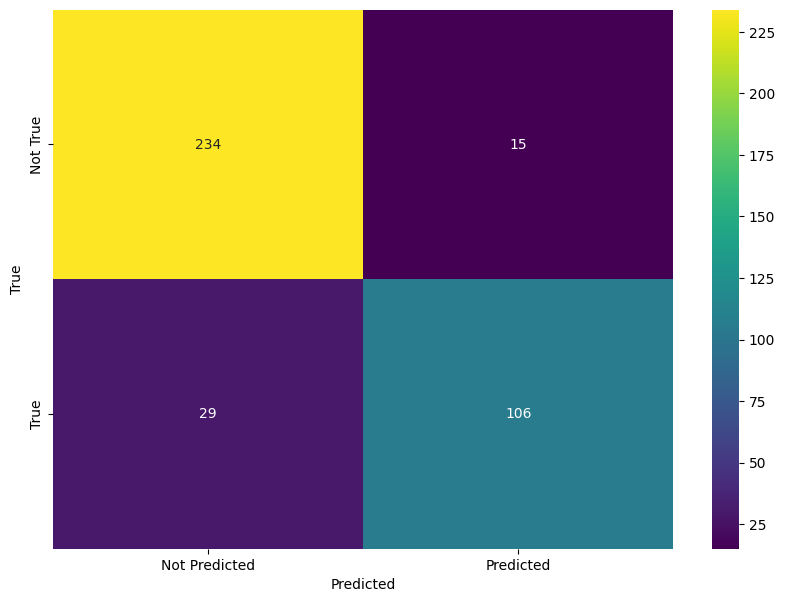

In [43]:
evaluate_predictions_single_matrix(test_dataset.labels, pred_labels_test)

Validation (single confusion matrix)

/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Class 0       0.96      1.00      0.98        22
     Class 1       1.00      1.00      1.00        23
     Class 2       1.00      0.18      0.31        11
     Class 3       0.00      0.00      0.00        10
     Class 4       0.78      1.00      0.88        18
     Class 5       0.00      0.00      0.00         5
     Class 6       0.00      0.00      0.00        10
     Class 7       0.78      1.00      0.88        18
     Class 8       0.00      0.00      0.00         6
     Class 9       1.00      1.00      1.00        23
    Class 10       0.00      0.00      0.00         2
    Class 11       0.00      0.00      0.00         4
    Class 12       0.00      0.00      0.00         3
    Class 13       0.00      0.00      0.00         2
    Class 14       0.00      0.00      0.00         0
    Class 15       0.00      0.00      0.00         1

   micro avg       0.91      0.67      0.77       158
   macro avg       0.35   

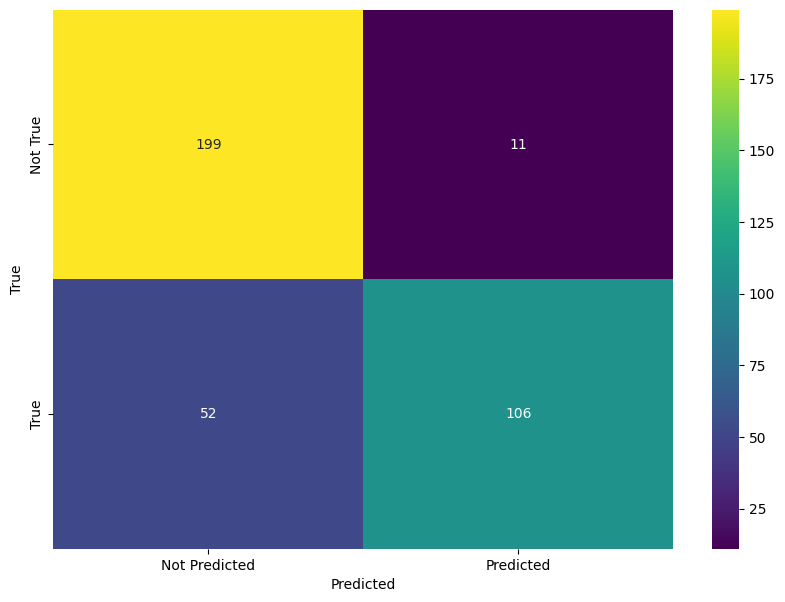

In [45]:
evaluate_predictions_single_matrix(val_dataset.labels, pred_labels)

In [46]:

def save_model(model, tokenizer, output_dir):
    """
    Saves the BERT model and tokenizer.

    Parameters:
    model (transformers.PreTrainedModel): The trained BERT model.
    tokenizer (transformers.PreTrainedTokenizer): The tokenizer associated with the model.
    output_dir (str): The directory where the model and tokenizer will be saved.

    Returns:
    None
    """
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    print(f"Model and tokenizer saved in {output_dir}")

In [58]:
# output_dir = './bert_exp25'
# save_model(model, tokenizer, output_dir)

# Testing with a different dataset (blackberry)

In [47]:
blackberry_dataset = fetch_and_preprocess_data(DATABASE_NAME, "blackberry_vendor", CONNECTION_STRING, preprocess=True,
                                               field_to_get="techniques", include_tactics=True)

[nltk_data] Downloading package punkt to /home/dalgora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dalgora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Shape: (300, 2)
                                              corpus  \
0  part continuous hunting efforts across asia-pa...   
1  late 2023 , blackberry analysts identified spe...   
2  report details resurgence lightspy mobile espi...   
3  networks underpin vital parts society frequent...   
4  financially motivated threat actor targeting m...   

                                             tactics  
0  [Resource Development, Initial Access, Executi...  
1  [Resource Development, Initial Access, Executi...  
2                                        [Execution]  
3                                                 []  
4  [Initial Access, Execution, Defense Evasion, C...  


In [48]:
bb_texts = blackberry_dataset['corpus'].tolist()

In [49]:
bb_tactics = blackberry_dataset['tactics'].apply(pd.Series).stack().reset_index(drop=True).unique()
one_hot_df = pd.get_dummies(blackberry_dataset['tactics'].apply(pd.Series).stack()).groupby(level=0).sum()
one_hot_df = one_hot_df.reindex(columns=bb_tactics, fill_value=0)

In [50]:
train_labels = df_one_hot_encoded.columns[2:]

# finding the missing columns
missing_columns = train_labels.difference(bb_tactics)

# adding missing columns with zeroes to the bb_one_hot_encoded dataframe
for column in missing_columns:
    one_hot_df[column] = 0

# reordering columns to match the train labels order
one_hot_df = one_hot_df[train_labels]


In [51]:
bb_labels = one_hot_df.values

In [52]:
"""output_dir = './bert_exp25'
tokenizer = BertTokenizer.from_pretrained(output_dir)
model = BertForSequenceClassification.from_pretrained(output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[+] Model in device: {device}")


model.to(device)"""

'output_dir = \'./bert_exp25\'\ntokenizer = BertTokenizer.from_pretrained(output_dir)\nmodel = BertForSequenceClassification.from_pretrained(output_dir)\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nprint(f"[+] Model in device: {device}")\n\n\nmodel.to(device)'

In [53]:
bb_encodings = tokenizer(list(bb_texts), truncation=True, padding=True)

In [54]:
bb_dataset = CustomDataset(bb_encodings, bb_labels)

## Evaluate on blackberry reports

In [55]:
def perform_inference(val_dataset):
    model.eval()
    dataloader = DataLoader(val_dataset, batch_size=8)
    pred_probs_list = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            outputs = model(**inputs)
            logits = outputs.logits
            pred_probs = torch.sigmoid(logits)
            pred_probs_list.append(pred_probs.cpu())

    pred_probs = torch.cat(pred_probs_list, dim=0)
    pred_labels = (pred_probs >= 0.5).int().numpy()
    return pred_labels

def evaluate_inference(true_labels, pred_labels):
    target_names = one_hot_df.columns

    print(classification_report(true_labels, pred_labels, target_names=target_names))
    cm = multilabel_confusion_matrix(true_labels, pred_labels)

    fig, axes = plt.subplots(nrows=cm.shape[0], figsize=(10, cm.shape[0] * 4))
    for i, ax in enumerate(axes):
        sns.heatmap(cm[i], annot=True, fmt='d', xticklabels=['Not ' + target_names[i], target_names[i]],
                    yticklabels=['Not ' + target_names[i], target_names[i]], ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'Confusion Matrix for {target_names[i]}')

    plt.tight_layout()
    plt.show()


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[+] Model in device: {device}")

[+] Model in device: cuda


/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalgora/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                      precision    recall  f1-score   support

           Execution             0.50      0.85      0.63        42
         Persistence             0.40      0.70      0.51        29
   Credential Access             0.10      0.50      0.17         3
          Collection             0.20      0.40      0.27         8
     Defense Evasion             0.35      0.70      0.47        19
Privilege Escalation             0.25      0.40      0.31         9
        Exfiltration             0.20      0.50      0.29        17
 Command and Control             0.40      0.70      0.51        21
           Discovery             0.25      0.55      0.34        18
      Initial Access             0.35      0.75      0.48        19
      Reconnaissance             0.10      0.40      0.16         1
    Lateral Movement             0.15      0.50      0.23         6
              Impact             0.20      0.40      0.27         8
Resource Development             0.15      0.50      

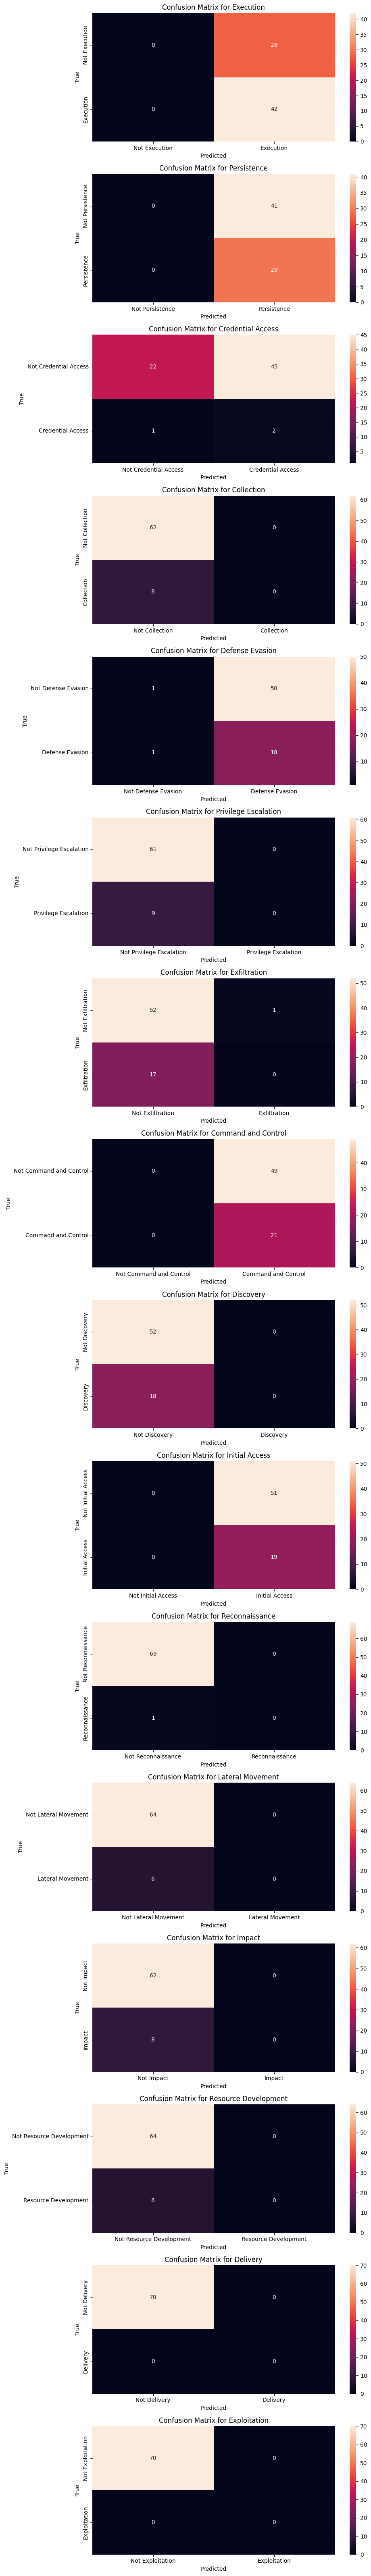

In [57]:
from sklearn.metrics import classification_report

pred_labels = perform_inference(bb_dataset)
classification_report(bb_labels, pred_labels)

print(classification_report)